# Roivant Clinical Trials Monte Carlo NPV
---
#### Goal: To evaluate the NPV of various drugs at various stages

##### Input:
- Drug Id (some identifier for a drug)
- Number of simulations
- List of Stages (Phase 2, Phase 3, NDA, Complete) as an example
- Start Year the year into a patent that Roivant obtains a drug
- yearly cost: the forcasted average cost per year
- yearly rev: the forcased average revenue to expect for each year
- cost_dist: the distribution function and function parameters that describe randomness in changes in the yearly cost 
- rev_dist: same as cost_dist but for revenue
- probs: a list of transition probabilities for each stage. For instance, if the durg has only NDA stage left stage_list = ('NDA', 'DONE') then the probability list would simply be [0.85] for instance because there is just one transition NDA -> (COMPLETE or FAIL)
---

##### Design:
My initial idea for behind the mc_trials package was to create a simple state machine. The possible pathways for a clinical trial can be thought of as a directed acyclic graph (DAG). For each state, there are two outcomes: Successfully move to the next trial or fail (ignoring the case that a trial could skip to a later stage). For instance, Pretrials can either move to Phase I or fail to move forward. While normal clinical trials follow a traditional path of Pre -> Phase I -> Phase II -> Phase III -> NDA -> DONE, I added a parameter called stage_list so that a user could override the pathway. This comes in handy if a drug has potential for skipping a stage and if the drug has already reached a later stage.

##### For the NPV calculations:
Assumption: Patents last 11 years - should parametrize in the future
User must include: 
- start_year: number of years into the patent
- yearly_costs: costs from the beginning of the patent life to the end
- yearly_rev: rev from beginning of patent to end
- cost_dist
- rev_dist
- initial_cost

start_year must be less than 11 or patent life
yearly_costs and revenue should be a list of length 11


##### Output:
Returns a list of tuples containing the following 
```
(<ENUM> DONE | FAILED, <State> State Object, <Float> NPV)
```

With this list, you can analyze the distribution of terminal states for a drug, how many outcomes resulted in a complete vs failed, and the NPV for these cuts

In [22]:
%matplotlib inline
from mc_trials import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Let's run an example simulation

In [29]:
sim = Simulation(
    1234, # some drug id
    10000, # num simulations
    stage_list=('P2','P3','NDA','DONE'),
    stage_len=[2,2,1,4],
    initial_cost=50,
    start_year=2,
    yearly_cost=[10., 10., 100., 100., 40., 10., 10., 20., 20., 10., 10.],
    yearly_rev = [0., 0., 0., 0., 0., 100., 500., 800., 700., 700., 500.],
    cost_dist = (np.random.normal, (0, 1)),
    rev_dist = (np.random.normal, (0, 10)),
    probs=[1, 1, 1] 
    # Notice: this is an impossible 
    # case of passing every stage 100% of the time
)

In [30]:
results = sim.run_simulation()

In [31]:
# the results list is a list of tuples 
# with (status, final state object, NPV)
print 'STATUS:', results[0][0], 'NPV:', results[0][2]

STATUS: DONE NPV: 1257.95649298


#### Plot the distribution

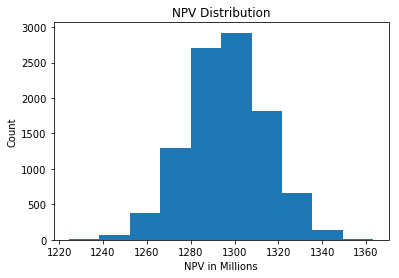

In [33]:
plt.hist([result[2] for result in results])
plt.title('NPV Distribution')
plt.xlabel('NPV in Millions')
plt.ylabel('Count')
plt.show()

#### A case where probability of success for each stage is less than 1

In [38]:
sim2 = Simulation(
    1234, # some drug id
    10000, # num simulations
    stage_list=('P2','P3','NDA','DONE'),
    stage_len=[2,2,1,4],
    initial_cost=50,
    start_year=2,
    yearly_cost=[10., 10., 100., 100., 40., 10., 10., 20., 20., 10., 10.],
    yearly_rev = [0., 0., 0., 0., 0., 100., 500., 800., 700., 700., 500.],
    cost_dist = (np.random.normal, (0, 1)),
    rev_dist = (np.random.normal, (0, 10)),
    probs=[.45, .6, .9] 
    # Notice: this is an impossible 
    # case of passing every stage 100% of the time
)

In [40]:
results2 = sim2.run_simulation()

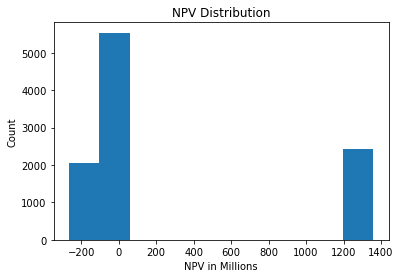

In [44]:
plt.hist([result[2] for result in results2])
plt.title('NPV Distribution')
plt.xlabel('NPV in Millions')
plt.ylabel('Count')
plt.show()

It seems odd that there are two sections to this distribution, but it makes sense

Since a drug is a "staged" investment, the only way a drug returns any potential for a positive payout is if the drug reaches completion. In this way, there is a distribution for both the case of failing and a case of succeeding. Let's split those out instead

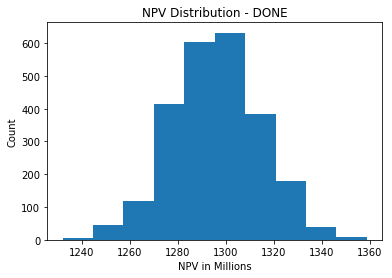

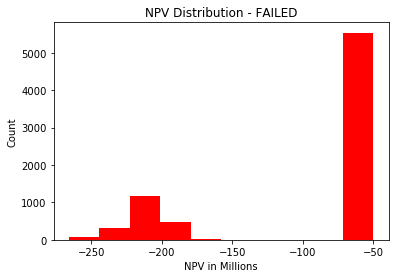

In [54]:
completed = filter(lambda x: x[0] == 'DONE', results2)
failed = filter(lambda x: x[0] == 'FAILED', results2)
plt.figure(1)
plt.hist([result[2] for result in completed])
plt.title('NPV Distribution - DONE')
plt.xlabel('NPV in Millions')
plt.ylabel('Count')

plt.figure(2)
plt.hist([result[2] for result in failed], facecolor='r')
plt.title('NPV Distribution - FAILED')
plt.xlabel('NPV in Millions')
plt.ylabel('Count')
plt.show()

The first plot shows the distribution of NPV for each instance that a drug passed all trials and made it to market. The second plot shows the distribution in which the drug never made it to completion.

#### How do we do this for a bunch of drugs?

In [34]:
df = pd.read_csv('drug_data.csv')

SPOOFED DATE BELOW:

In [37]:
df.head(11)

,drug_id,num_trials,stage_list,start_year,stage_len,initial_cost,yearly_cost,yearly_rev,cost_dist,rev_dist,probs,distributions
0,1,10000,"P2,P3,NDA,DONE",2,"1,3,1,4",50,"1,2,5,5,1,2","0,0,0,0,0,15,100,200","normal,0,1","normal,0,1",".5,.5,.6,.7",-
1,2,10000,"P2,P3,NDA,DONE",2,"1,3,1,5",60,"1,2,5,5,1,3","0,0,0,0,0,15,100,201","normal,0,2","normal,0,1",".5,.5,.6,.7",-
2,3,10000,"P2,P3,NDA,DONE",3,"1,3,1,6",30,"1,2,5,5,1,4","0,0,0,0,0,15,100,202","normal,0,3","normal,0,1",".5,.5,.6,.7",-
3,4,10000,"P1,P2,P3,NDA,DONE",1,"1,3,1,7",20,"1,2,5,5,1,5","0,0,0,0,0,15,100,203","normal,0,4","normal,0,1",".5,.5,.6,.7",-
4,5,10000,"PRE,P1,P2,P3,NDA,DONE",0,"1,3,1,8",22,"1,2,5,5,1,6","0,0,0,0,0,15,100,204","normal,0,5","normal,0,1",".5,.5,.6,.7",-
5,6,10000,"PRE,P1,P2,P3,NDA,DONE",0,"1,3,1,9",25,"1,2,5,5,1,7","0,0,0,0,0,15,100,205","normal,0,6","normal,0,1",".5,.5,.6,.7",-
6,7,10000,"PRE,P1,P2,P3,NDA,DONE",0,"1,3,1,10",70,"1,2,5,5,1,8","0,0,0,0,0,15,100,206","normal,0,7","normal,0,1",".5,.5,.6,.7",-
7,8,10000,"P1,P2,P3,NDA,DONE",1,"1,3,1,11",40,"1,2,5,5,1,9","0,0,0,0,0,15,100,207","normal,0,8","normal,0,1",".5,.5,.6,.7",-
8,9,10000,"P3,NDA,DONE",3,"1,3,1,12",20,"1,2,5,5,1,10","0,0,0,0,0,15,100,208","normal,0,9","normal,0,1",".5,.5,.6,.7",-
9,10,10000,"P3,NDA,DONE",4,"1,3,1,13",52,"1,2,5,5,1,11","0,0,0,0,0,15,100,209","normal,0,10","normal,0,1",".5,.5,.6,.7",-


We can take a list of drug ids, num trials, and all the other parameters, and then run this list through a simulation and return a distribution.

NOTE: This data is all spoofed and most points do not make sense as an input

#### Next Steps:
---
- Configurable Patent Length
- Allow a distribution for each step in yearly revenue and cost
- Analyze the distrubitions from Monte Carlo simulations for an ensemble of drugs to determine which drugs have the best NPV's
- Evaluate what kind of distributions arise for revenue and cost of pharma products